<a href="https://colab.research.google.com/github/farisazizy/CNN-optimization-cuckoo/blob/main/CNN_Optimization_Graph_and_Result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
pip install niapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.9/181.9 kB 8.3 MB/s eta 0:00:00


In [ ]:
import os

from PIL import Image

import cv2
import numpy as np
import pickle
import tensorflow as tf
import keras
import joblib
import random
import pandas as pd
import math
import itertools

from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.utils import to_categorical

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.datasets import cifar10

from niapy.algorithms.basic import CuckooSearch
from niapy.problems import Problem
from niapy.task import OptimizationType, Task

import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open("/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/xtrain.pickle", 'rb') as f:
  x_train = pickle.load(f)

with open("/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/ytrain.pickle", 'rb') as f:
  y_train = pickle.load(f)

with open("/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/xtest.pickle", 'rb') as f:
  x_test = pickle.load(f)

with open("/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/ytest.pickle", 'rb') as f:
  y_test = pickle.load(f)

with open("/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/xval.pickle", 'rb') as f:
  x_val = pickle.load(f)

with open("/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/yval.pickle", 'rb') as f:
  y_val = pickle.load(f)

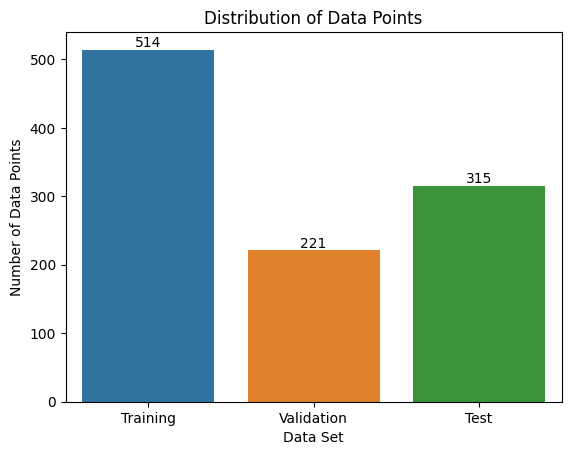

In [ ]:
data_counts = [len(x_train), len(x_val), len(x_test)]
set_names = ['Training', 'Validation', 'Test']

df = pd.DataFrame({'Data Count': data_counts, 'Set': set_names})

# Plot
ax = sns.barplot(data=df, x='Set', y='Data Count')
plt.xlabel('Data Set')
plt.ylabel('Number of Data Points')
plt.title('Distribution of Data Points')

for i, count in enumerate(data_counts):
    ax.text(i, count, str(count), ha='center', va='bottom')

plt.show()


In [ ]:
pop20 = joblib.load('/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/best_paramsPOP20.pkl')
pop25 = joblib.load('/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/best_paramsPOP25.pkl')
pop30 = joblib.load('/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/best_paramsPOP30.pkl')
conv20 = joblib.load('/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/convg_dataPOP20.pkl')
conv25 = joblib.load('/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/convg_dataPOP25.pkl')
conv30 = joblib.load('/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/convg_dataPOP30.pkl')

params = {}
convergence_data = {}
params = {**pop20, **pop25, **pop30}
convergence_data = {**conv20, **conv25, **conv30}

In [ ]:
population = [20, 25, 30]
pa = [0.20, 0.25, 0.30]

# Needed Function

In [ ]:
def get_hyperparameters(x):
    """Get hyperparameters for solution `x`."""
    conv_layers = int(x[0] * 3) + 1
    filter_size = int(2 + x[1] * 1)
    filter_num1 = int(32 + x[2] * 96) #128
    filter_num2 = int(32 + x[3] * 96)
    filter_num3 = int(32 + x[4] * 96)
    filter_num4 = int(32 + x[5] * 96)
    filter_num = [filter_num1, filter_num2, filter_num3, filter_num4]
    pool_type = 'max' if x[6] < 0.5 else 'avg'
    pool_size = int(2 + x[7] * 1)
    fc_layer_size = int(128 + x[8] * 128) #256
    optimizers = ['Adam', 'SGD', 'RMSprop']
    optimizer = optimizers[int(x[9] * 2)]

    params = {
        'conv_layers': conv_layers,
        'filter_size': filter_size,
        'filter_num': filter_num,
        'pool_type': pool_type,
        'pool_size': pool_size,
        'fc_layer_size': fc_layer_size,
        'optimizer': optimizer,
    }
    return params

In [ ]:
SEED = 0
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [ ]:
def get_model(x):
    """Build a CNN model based on hyperparameters `x`."""
    params = get_hyperparameters(x)

    set_seeds()

    # Define the model architecture
    model = Sequential()

    model.add(Conv2D(params['filter_num'][0], (params['filter_size'], params['filter_size']),
                     activation='relu', padding='same', input_shape=(128, 128, 1)))
    if params['pool_type'] == 'max':
        model.add(MaxPooling2D(pool_size=(params['pool_size'], params['pool_size'])))
    elif params['pool_type'] == 'avg':
        model.add(AveragePooling2D(pool_size=(params['pool_size'], params['pool_size'])))

    for i in range(params['conv_layers'] - 1):
        model.add(Conv2D(params['filter_num'][i+1], (params['filter_size'], params['filter_size']),
                         activation='relu', padding='same'))
        if params['pool_type'] == 'max':
            model.add(MaxPooling2D(pool_size=(params['pool_size'], params['pool_size'])))
        elif params['pool_type'] == 'avg':
            model.add(AveragePooling2D(pool_size=(params['pool_size'], params['pool_size'])))

    model.add(Flatten())
    model.add(Dense(params['fc_layer_size'], activation='relu'))
    model.add(Dense(3, activation='softmax'))

    # Map optimizer name to Keras optimizer object
    optimizer = params['optimizer']

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [ ]:
class CNNHyperparameterOptimization(Problem):
    def __init__(self, x_train, y_train, x_val, y_val):
        super().__init__(dimension=10, lower=0, upper=1)
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val

    def _evaluate(self, x):
        model = get_model(x)
        early_stop = EarlyStopping(monitor='val_loss', patience=2)
        history = model.fit(self.x_train, self.y_train, epochs=10, batch_size=32, verbose=0, validation_data=(self.x_val, self.y_val), callbacks=[early_stop])

        return history.history['val_accuracy'][-1]

# Convergence Plot



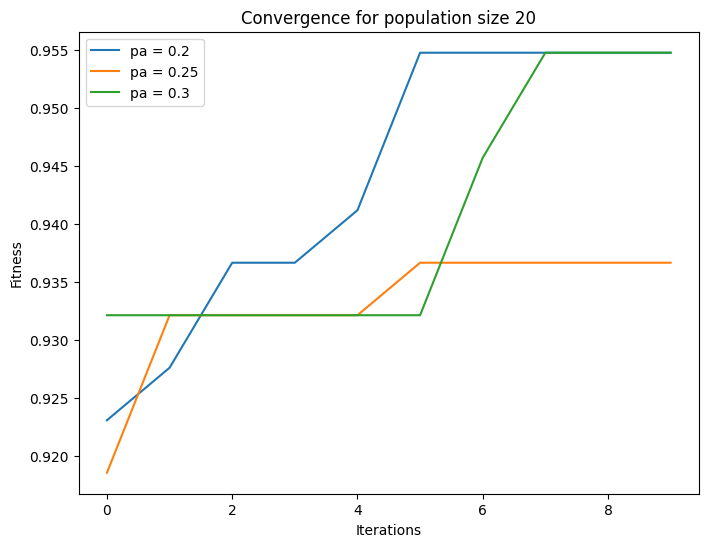

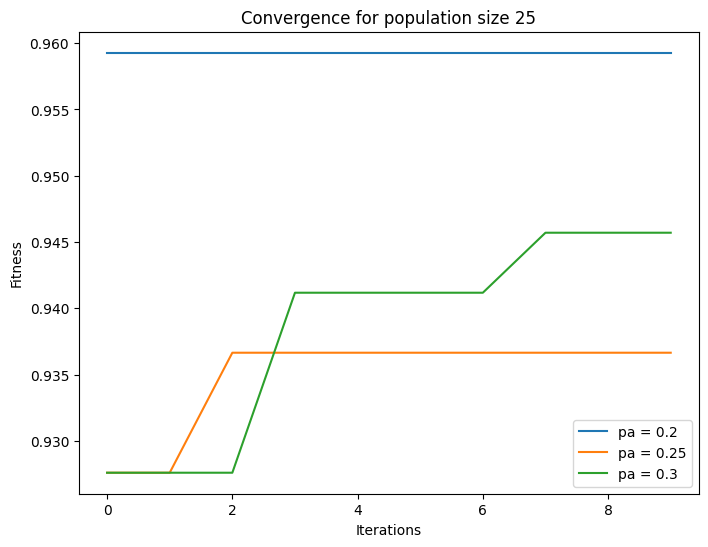

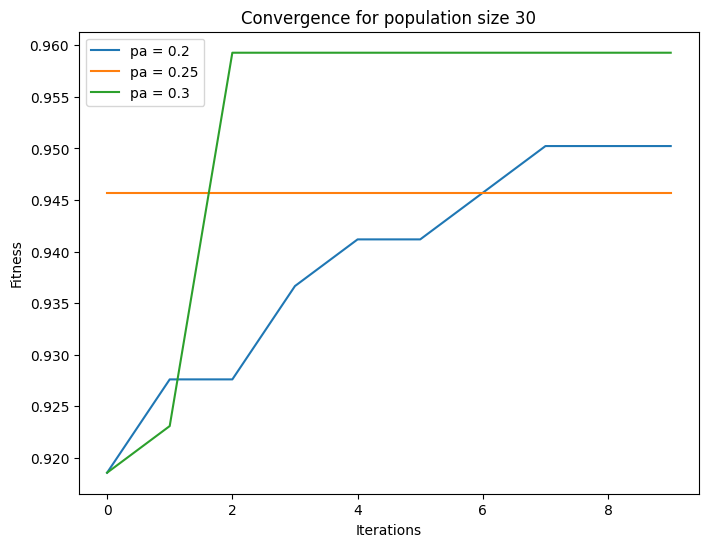

In [ ]:
# Plot convergence graphs for each population size + pa

for pop_size in population:
    fig, ax = plt.subplots(figsize=(8, 6))
    for pa_val in pa:
        conv_data = convergence_data[(pop_size, pa_val)]
        x, y = conv_data
        label = f'pa = {pa_val}'
        ax.plot(x, y, label=label)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Fitness')
    ax.set_title(f'Convergence for population size {pop_size}')
    ax.legend()
    plt.show()

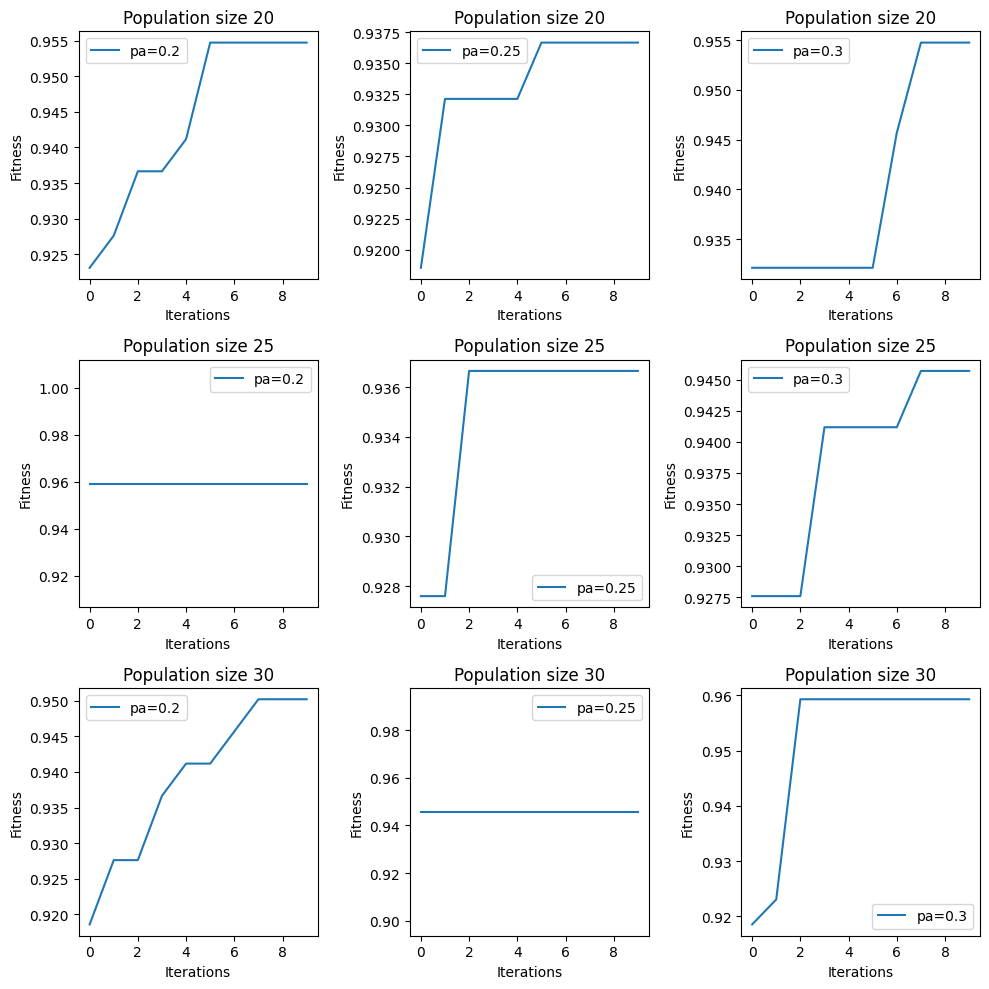

In [ ]:
# Plot convergence graphs for all population sizes
import math

num_pop_sizes = len(convergence_data)
num_cols = 3
num_rows = math.ceil(num_pop_sizes / num_cols)

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 10))
axs = axs.flatten()

for idx, (pop_size, conv_data) in enumerate(convergence_data.items()):
    x, y = conv_data
    ax = axs[idx]
    label = f'pa={pop_size[1]}'
    ax.plot(x, y, label=label)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Fitness')
    ax.set_title(f'Population size {pop_size[0]}')
    ax.legend()

# Hide unused subplot axes
for i in range(num_pop_sizes, num_rows * num_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()


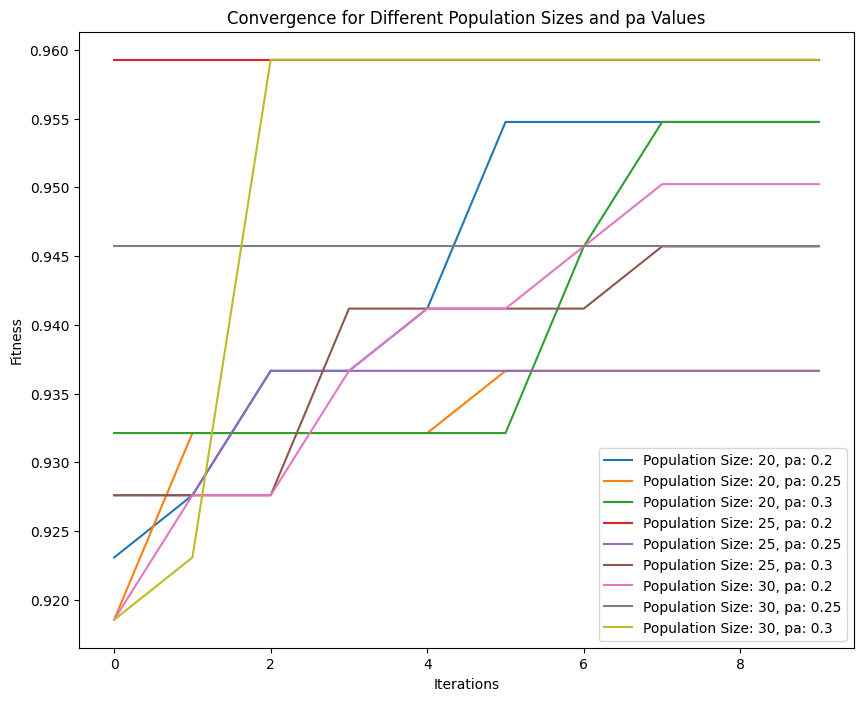

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

for pop_size in population:
    for pa_val in pa:
        conv_data = convergence_data[(pop_size, pa_val)]
        x, y = conv_data
        label = f'Population Size: {pop_size}, pa: {pa_val}'
        ax.plot(x, y, label=label)

ax.set_xlabel('Iterations')
ax.set_ylabel('Fitness')
ax.set_title('Convergence for Different Population Sizes and pa Values')
ax.legend()
plt.show()

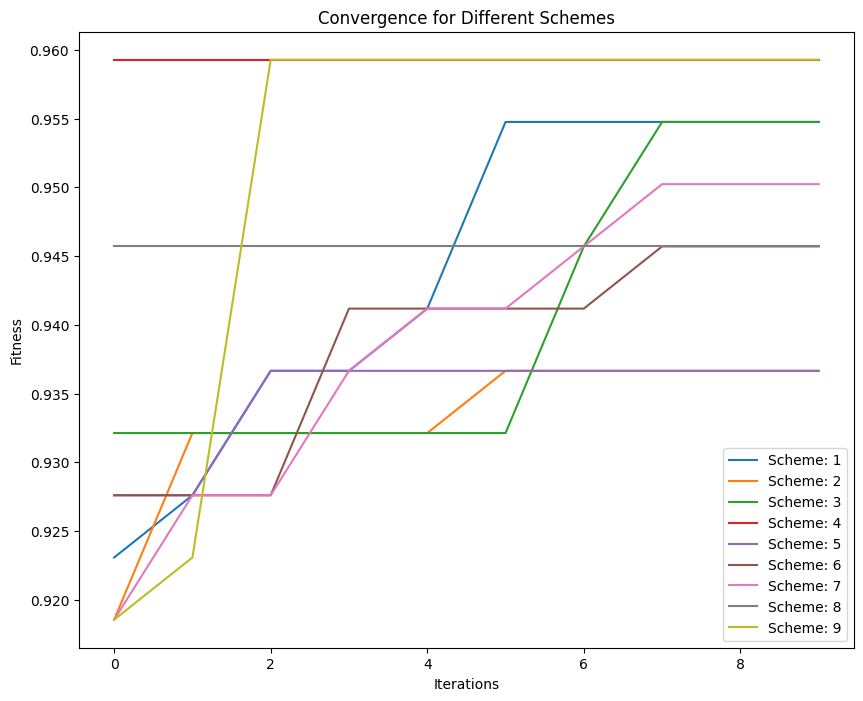

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

i = 1
for pop_size in population:
    for pa_val in pa:
        conv_data = convergence_data[(pop_size, pa_val)]
        x, y = conv_data
        label = f'Scheme: {i}'
        ax.plot(x, y, label=label)
        i+=1

ax.set_xlabel('Iterations')
ax.set_ylabel('Fitness')
ax.set_title('Convergence for Different Schemes')
ax.legend()
plt.show()

# Learning Curve

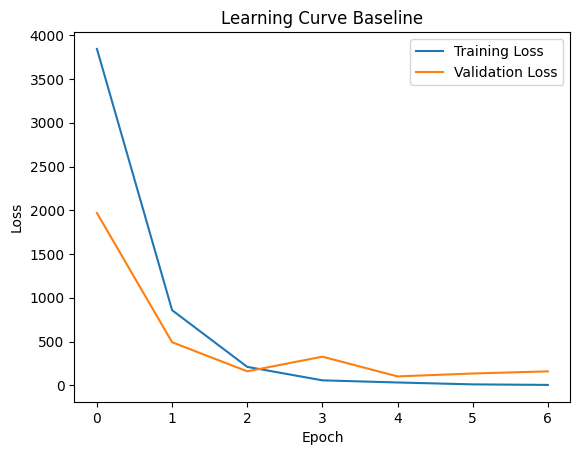

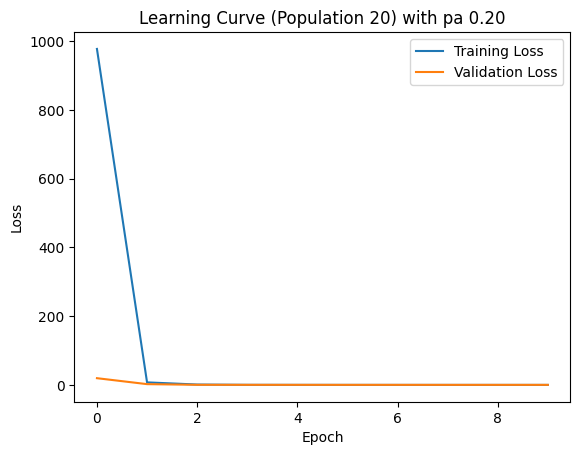

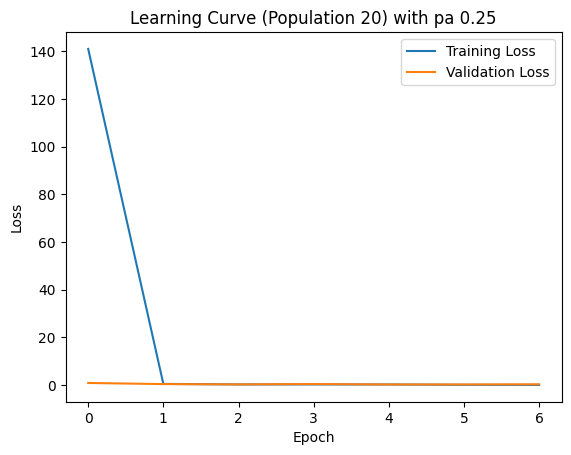

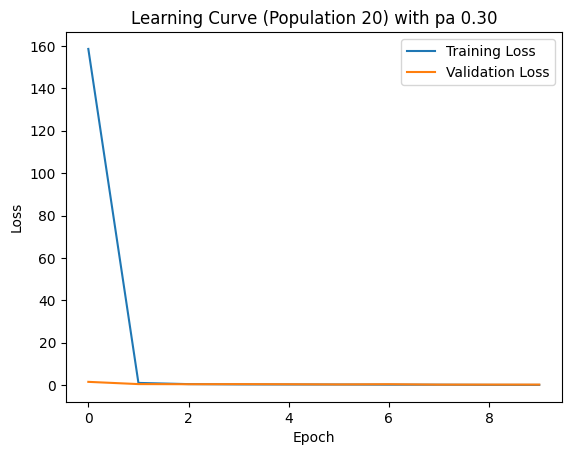

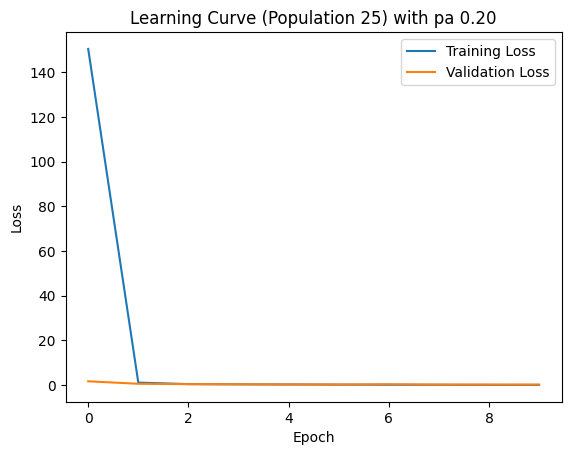

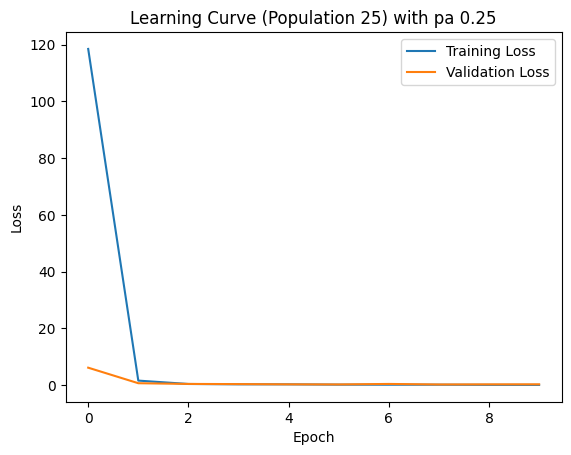

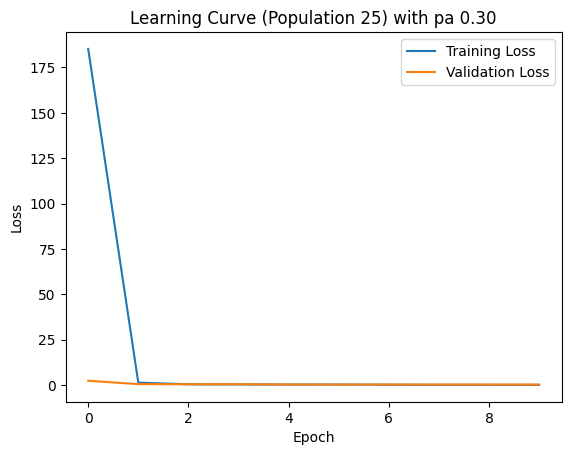

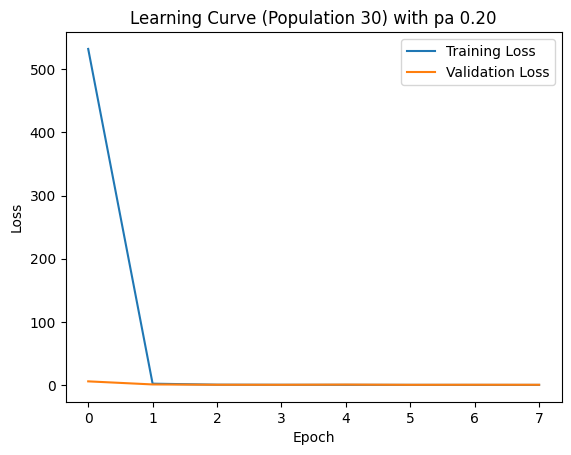

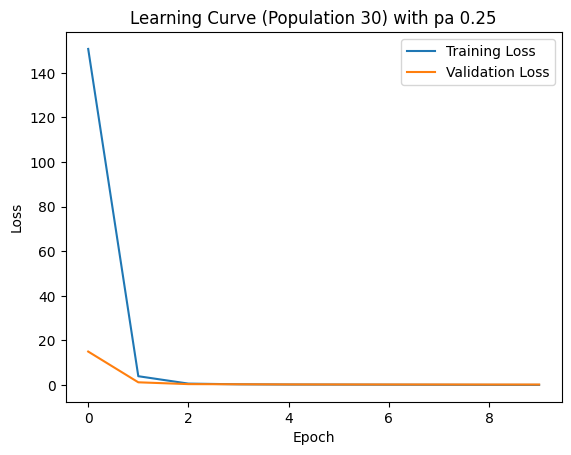

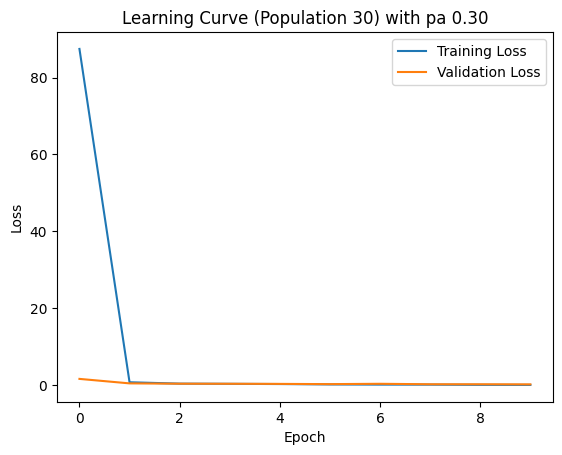

In [ ]:
# Define the directory to save the models and history
save_dir = '/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/Model'

# Plot the learning curve and convergence plot for each model
for i, pop_size in enumerate(population):
    for j, pa_val in enumerate(pa):
        # Load the history from the saved model
        model_name = f'pop_{pop_size}_pa_{pa_val}.h5'
        model_path = os.path.join(save_dir, model_name)
        history = joblib.load(f'/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/Model/pop_{pop_size}_pa_{pa_val}_history.pkl')

        # Plot the learning curve
        plt.plot(history['loss'], label='Training Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        title = 'Learning Curve (Population {}) with pa {:.2f}'.format(pop_size, pa_val)
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


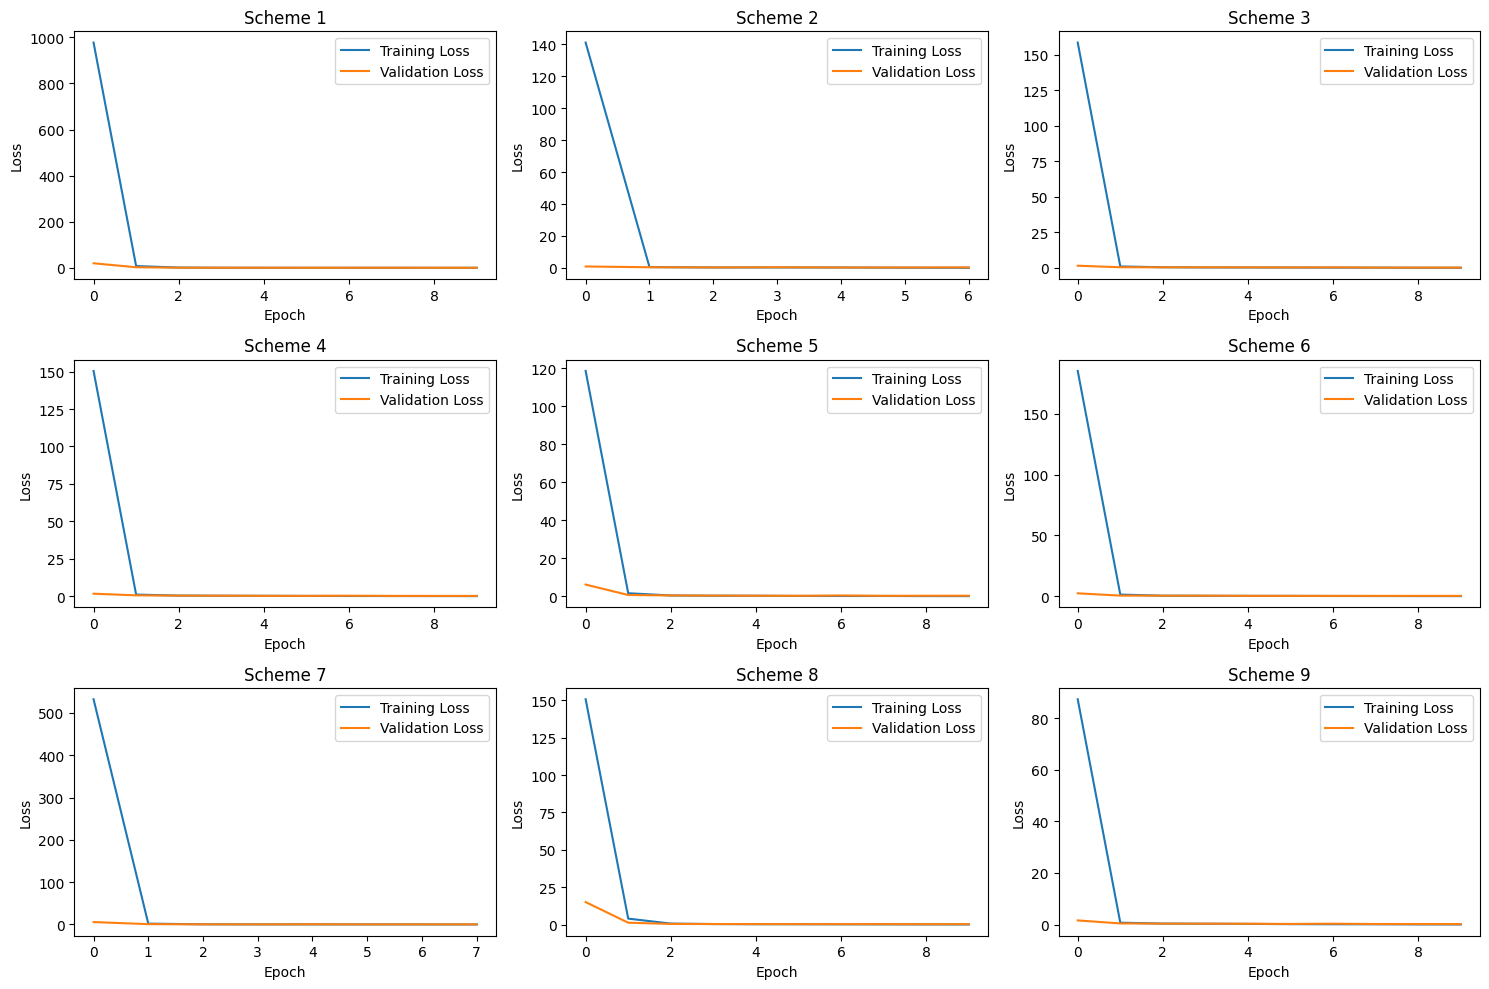

In [ ]:
save_dir = '/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/Model'

# Define the number of columns for subplots
num_cols = 3

# Calculate the number of rows for subplots
num_rows = math.ceil(len(population) * len(pa) / num_cols)

# Create the subplots
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))
axs = axs.flatten()

i = 1
# Plot the learning curve and convergence plot for each model
for idx, (pop_size, pa_val) in enumerate(itertools.product(population, pa)):
    # Load the history from the saved model
    model_name = f'pop_{pop_size}_pa_{pa_val}.h5'
    model_path = os.path.join(save_dir, model_name)
    history = joblib.load(f'/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/Model/pop_{pop_size}_pa_{pa_val}_history.pkl')

    # Select the current axis
    ax = axs[idx]

    # Plot the learning curve
    ax.plot(history['loss'], label='Training Loss')
    ax.plot(history['val_loss'], label='Validation Loss')
    title = 'Scheme {}'.format(i)
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    i+=1

# Hide unused subplot axes
for i in range(len(population) * len(pa), num_rows * num_cols):
    fig.delaxes(axs[i])

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


# Confusion Matrix & Accuracy

In [ ]:
class_names = ["Meningioma", "Glioma", "Pituitary"]

In [ ]:
model_dir = '/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/Model'
model_files = [f for f in os.listdir(model_dir) if f.endswith('.h5')]

for filename in model_files:
    # Load the saved model
    model_path = os.path.join(model_dir, filename)
    model = load_model(model_path)

    # Make predictions on the train set
    y_pred = model.predict(x_train)
    y_pred = np.argmax(y_pred, axis=1)

    y_true = np.argmax(y_train, axis=1)

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    # Print the confusion matrix and accuracy score
    print('---------------------------------------------')
    print(f"Confusion Matrix ({filename}):")
    print(cm_df)
    print('')
    score = model.evaluate(x_test, y_test)
    print('Model accuracy:', score)
    # acc = np.sum(np.diag(cm)) / np.sum(cm)
    # print(f"Accuracy Score ({filename}): {acc:.4f}\n")
    print('---------------------------------------------')



17/17 [==============================] - 4s 251ms/step
---------------------------------------------
Confusion Matrix (baseline.h5):
            Meningioma  Glioma  Pituitary
Meningioma         173       0          2
Glioma               4     161          0
Pituitary            0       0        174

10/10 [==============================] - 2s 189ms/step - loss: 152.3780 - accuracy: 0.8857
Model accuracy: [152.3779754638672, 0.8857142925262451]
---------------------------------------------
17/17 [==============================] - 7s 402ms/step
---------------------------------------------
Confusion Matrix (pop_20_pa_0.2.h5):
            Meningioma  Glioma  Pituitary
Meningioma         175       0          0
Glioma               0     165          0
Pituitary            0       0        174

10/10 [==============================] - 4s 320ms/step - loss: 0.3036 - accuracy: 0.9111
Model accuracy: [0.3036080300807953, 0.9111111164093018]
---------------------------------------------
17/17 

In [ ]:
model_dir = '/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/Model'
model_files = [f for f in os.listdir(model_dir) if f.endswith('.h5')]

for filename in model_files:
    # Load the saved model
    model_path = os.path.join(model_dir, filename)
    model = load_model(model_path)

    # Make predictions on the train set
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)

    y_true = np.argmax(y_test, axis=1)

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    # Print the confusion matrix and accuracy score
    print('---------------------------------------------')
    print(f"Confusion Matrix ({filename}):")
    print(cm_df)
    print('')
    score = model.evaluate(x_test, y_test)
    print('Model accuracy:', score)
    # acc = np.sum(np.diag(cm)) / np.sum(cm)
    # print(f"Accuracy Score ({filename}): {acc:.4f}\n")
    print('---------------------------------------------')



10/10 [==============================] - 2s 220ms/step
---------------------------------------------
Confusion Matrix (baseline.h5):
            Meningioma  Glioma  Pituitary
Meningioma          95       2          6
Glioma              28      77          0
Pituitary            0       0        107

10/10 [==============================] - 2s 218ms/step - loss: 152.3780 - accuracy: 0.8857
Model accuracy: [152.3779754638672, 0.8857142925262451]
---------------------------------------------
10/10 [==============================] - 5s 501ms/step
---------------------------------------------
Confusion Matrix (pop_20_pa_0.2.h5):
            Meningioma  Glioma  Pituitary
Meningioma          89      12          2
Glioma              14      91          0
Pituitary            0       0        107

10/10 [==============================] - 4s 316ms/step - loss: 0.3036 - accuracy: 0.9111
Model accuracy: [0.3036080300807953, 0.9111111164093018]
---------------------------------------------
10/10 

# Best Params Summary

Best parameter is on Population 30 with pa = 0.3 with Accuracy **0.927** on data test

In [ ]:
params

{(20, 0.2): (0.9547511339187622,
  array([3.52501759e-01, 6.41759956e-01, 3.04781540e-01, 5.47017742e-01,
         8.86688216e-01, 3.59295563e-04, 7.21228338e-01, 6.47532941e-01,
         9.97987048e-01, 8.36342154e-03])),
 (20, 0.25): (0.9366515874862671,
  array([0.99745005, 0.88991045, 0.98540833, 0.49363331, 0.47837298,
         0.40164051, 0.98626295, 0.82813681, 0.28399313, 0.45633308])),
 (20, 0.3): (0.9547511339187622,
  array([0.82576972, 1.        , 0.37624545, 0.27654388, 0.85585903,
         0.282385  , 0.73178239, 0.66656057, 0.48817326, 0.1764596 ])),
 (25, 0.2): (0.959276020526886,
  array([0.87283109, 0.97572838, 0.59295167, 0.34289663, 0.54467275,
         0.53992535, 0.68438146, 0.12886625, 0.03554323, 0.15683908])),
 (25, 0.25): (0.9366515874862671,
  array([0.79642429, 0.02571585, 0.84590134, 0.49113965, 0.49537412,
         0.27003747, 0.53519061, 0.        , 0.46367474, 0.04519378])),
 (25, 0.3): (0.9457013607025146,
  array([0.87528718, 0.6220852 , 0.98986116, 0.

In [ ]:
params[(25, 0.25)][1]

In [ ]:
for i in range(len(population)):
  for j in range(len(pa)):
    print((population[i], pa[j]), '', get_hyperparameters(params[(population[i], pa[j])][1]))

(20, 0.2)  {'conv_layers': 2, 'filter_size': 2, 'filter_num': [61, 84, 117, 32], 'pool_type': 'avg', 'pool_size': 2, 'fc_layer_size': 255, 'optimizer': 'Adam'}
(20, 0.25)  {'conv_layers': 3, 'filter_size': 2, 'filter_num': [126, 79, 77, 70], 'pool_type': 'avg', 'pool_size': 2, 'fc_layer_size': 164, 'optimizer': 'Adam'}
(20, 0.3)  {'conv_layers': 3, 'filter_size': 3, 'filter_num': [68, 58, 114, 59], 'pool_type': 'avg', 'pool_size': 2, 'fc_layer_size': 190, 'optimizer': 'Adam'}
(25, 0.2)  {'conv_layers': 3, 'filter_size': 2, 'filter_num': [88, 64, 84, 83], 'pool_type': 'avg', 'pool_size': 2, 'fc_layer_size': 132, 'optimizer': 'Adam'}
(25, 0.25)  {'conv_layers': 3, 'filter_size': 2, 'filter_num': [113, 79, 79, 57], 'pool_type': 'avg', 'pool_size': 2, 'fc_layer_size': 187, 'optimizer': 'Adam'}
(25, 0.3)  {'conv_layers': 3, 'filter_size': 2, 'filter_num': [127, 70, 91, 98], 'pool_type': 'avg', 'pool_size': 2, 'fc_layer_size': 245, 'optimizer': 'Adam'}
(30, 0.2)  {'conv_layers': 2, 'filter_s

In [ ]:
bestparam = (params[(30, 0.3)][1])
bestparam

array([0.95952295, 0.75198183, 0.39210653, 0.69448297, 0.25273069,
       1.        , 0.77856112, 0.05968044, 1.        , 0.37790416])

In [ ]:
get_hyperparameters(bestparam)

{'conv_layers': 3,
 'filter_size': 2,
 'filter_num': [69, 98, 56, 128],
 'pool_type': 'avg',
 'pool_size': 2,
 'fc_layer_size': 256,
 'optimizer': 'Adam'}

In [ ]:
model_dir = '/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/Model'
model_path = os.path.join(model_dir, 'pop_30_pa_0.3.h5')
model = load_model(model_path)

# Make predictions on the train set
y_pred = model.predict(x_train)
y_pred = np.argmax(y_pred, axis=1)

y_true = np.argmax(y_train, axis=1)

#importing confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_true, y_pred)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_true, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_true, y_pred, target_names=['Meningioma', 'Glioma', 'Pituitary']))

17/17 [==============================] - 10s 517ms/step
Confusion Matrix

[[175   0   0]
 [  0 165   0]
 [  0   0 174]]

Accuracy: 1.00

Micro Precision: 1.00
Micro Recall: 1.00
Micro F1-score: 1.00

Macro Precision: 1.00
Macro Recall: 1.00
Macro F1-score: 1.00

Weighted Precision: 1.00
Weighted Recall: 1.00
Weighted F1-score: 1.00

Classification Report

              precision    recall  f1-score   support

  Meningioma       1.00      1.00      1.00       175
      Glioma       1.00      1.00      1.00       165
   Pituitary       1.00      1.00      1.00       174

    accuracy                           1.00       514
   macro avg       1.00      1.00      1.00       514
weighted avg       1.00      1.00      1.00       514



In [ ]:
class_acc = []
for i in range(3):
    correct_predictions = cm[i, i]
    total_samples = np.sum(cm[i, :])
    accuracy = correct_predictions / total_samples
    class_acc.append(accuracy)

for i, acc in enumerate(class_acc):
    class_name = class_names[i]
    print(f"Accuracy for class {class_name}: {acc:.4f}")


Accuracy for class Meningioma: 0.8932
Accuracy for class Glioma: 0.8857
Accuracy for class Pituitary: 1.0000


# Image Plot

In [ ]:
model_path = os.path.join(model_dir, 'pop_30_pa_0.2.h5')
model = load_model(model_path)

# Make predictions on the train set
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

y_true = np.argmax(y_test, axis=1)

10/10 [==============================] - 5s 470ms/step


In [ ]:
for i in range(len(y_pred)):
  print(y_true[i], y_pred[i], i)

1 0 0
1 1 1
2 2 2
1 1 3
2 2 4
2 2 5
2 2 6
1 1 7
1 1 8
1 1 9
0 0 10
1 0 11
2 2 12
1 1 13
0 0 14
0 0 15
0 0 16
0 0 17
1 1 18
2 2 19
1 1 20
2 2 21
2 2 22
0 0 23
0 2 24
0 0 25
1 1 26
1 0 27
0 0 28
1 0 29
1 1 30
2 2 31
2 2 32
2 2 33
0 0 34
0 0 35
1 1 36
2 2 37
0 0 38
1 1 39
1 1 40
1 1 41
2 2 42
1 1 43
0 0 44
2 2 45
2 1 46
1 1 47
1 1 48
1 1 49
0 0 50
1 1 51
2 2 52
2 2 53
0 0 54
2 2 55
2 2 56
0 0 57
2 2 58
1 1 59
1 0 60
2 2 61
0 0 62
2 2 63
2 2 64
2 2 65
1 1 66
1 1 67
1 1 68
1 1 69
2 2 70
0 0 71
2 2 72
2 2 73
1 1 74
2 2 75
1 0 76
1 1 77
1 1 78
2 2 79
2 2 80
0 0 81
1 1 82
1 1 83
1 1 84
1 1 85
2 2 86
2 1 87
0 0 88
2 2 89
1 1 90
2 2 91
2 2 92
0 0 93
2 2 94
2 2 95
2 2 96
2 2 97
2 2 98
2 2 99
2 2 100
0 0 101
2 2 102
0 0 103
1 1 104
1 1 105
2 2 106
2 2 107
2 2 108
2 2 109
0 1 110
2 2 111
1 0 112
2 2 113
1 1 114
0 2 115
0 0 116
2 2 117
2 2 118
0 0 119
2 2 120
0 0 121
1 1 122
0 0 123
2 2 124
1 1 125
0 0 126
0 0 127
1 0 128
1 1 129
2 2 130
2 2 131
2 2 132
0 0 133
1 1 134
0 0 135
0 0 136
0 0 137
0 0 13

<Figure size 640x480 with 0 Axes>

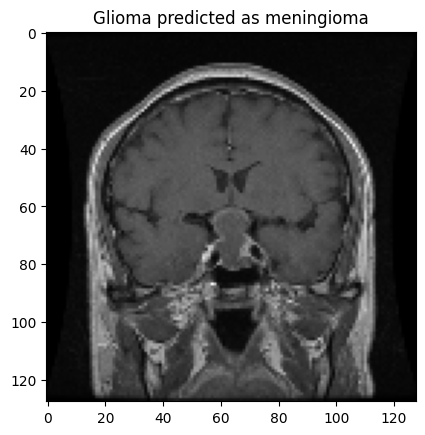

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.gray()
plt.title('Glioma predicted as meningioma')
# plt.imshow(x_train[29])
plt.imshow(x_train[246])
plt.figure()

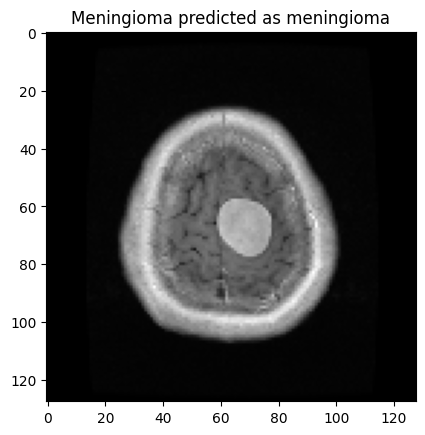

<Figure size 640x480 with 0 Axes>

In [ ]:
for i in range(len(y_pred)):
  if y_true[i] == 0 and y_pred[i] == 0:
    plt.gray()
    plt.title('Meningioma predicted as meningioma')
    plt.imshow(x_train[i])
    plt.figure()
    break

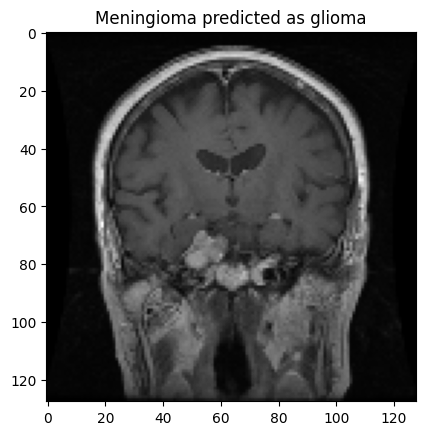

<Figure size 640x480 with 0 Axes>

In [ ]:
for i in range(len(y_pred)):
  if y_true[i] == 0 and y_pred[i] == 1:
    plt.gray()
    plt.title('Meningioma predicted as glioma')
    plt.imshow(x_train[i])
    plt.figure()
    break

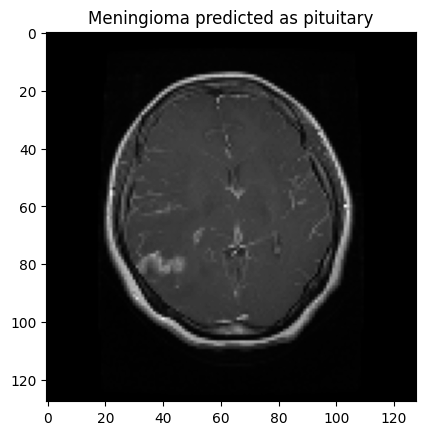

<Figure size 640x480 with 0 Axes>

In [ ]:
for i in range(len(y_pred)):
  if y_true[i] == 0 and y_pred[i] == 2:
    plt.gray()
    plt.title('Meningioma predicted as pituitary')
    plt.imshow(x_train[i])
    plt.figure()
    break

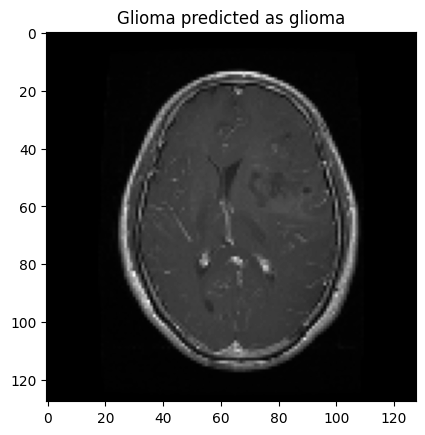

<Figure size 640x480 with 0 Axes>

In [ ]:
for i in range(len(y_pred)):
  if y_true[i] == 1 and y_pred[i] == 1:
    plt.gray()
    plt.title('Glioma predicted as glioma')
    plt.imshow(x_train[i])
    plt.figure()
    break

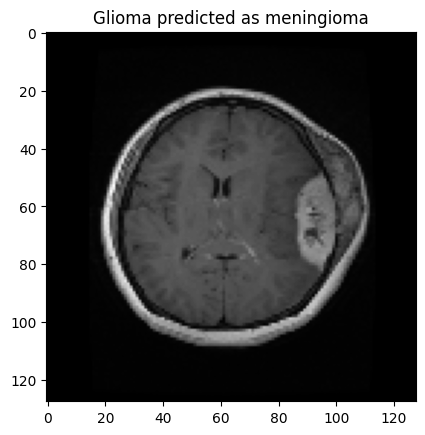

<Figure size 640x480 with 0 Axes>

In [ ]:
for i in range(len(y_pred)):
  if y_true[i] == 1 and y_pred[i] == 0:
    plt.gray()
    plt.title('Glioma predicted as meningioma')
    plt.imshow(x_train[i])
    plt.figure()
    break

<Figure size 640x480 with 0 Axes>

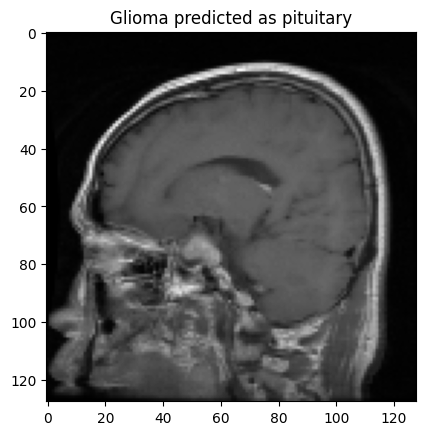

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.gray()
plt.title('Glioma predicted as pituitary')
plt.imshow(x_train[308])
plt.figure()

<Figure size 640x480 with 0 Axes>

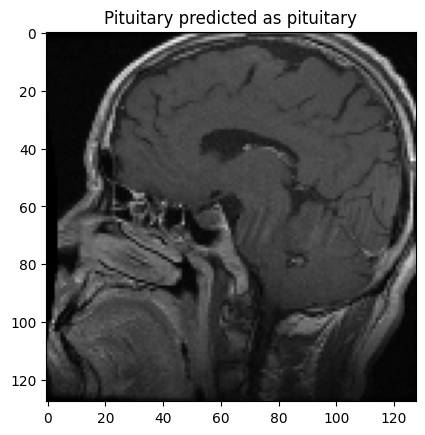

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.gray()
plt.title('Pituitary predicted as pituitary')
plt.imshow(x_train[65])
plt.figure()

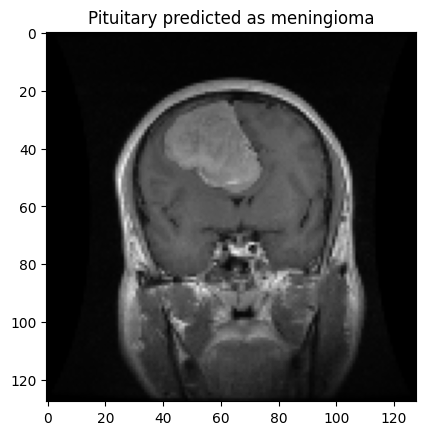

<Figure size 640x480 with 0 Axes>

In [ ]:
for i in range(len(y_pred)):
  if y_true[i] == 2 and y_pred[i] == 0:
    plt.gray()
    plt.title('Pituitary predicted as meningioma')
    plt.imshow(x_train[i])
    plt.figure()
    break

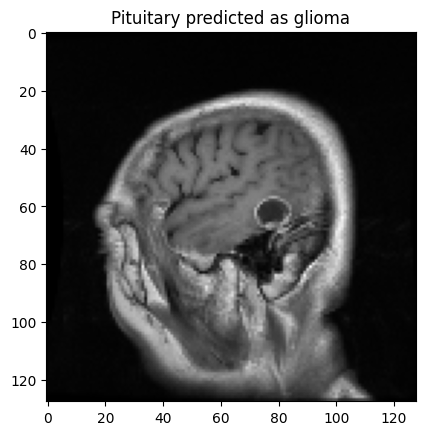

<Figure size 640x480 with 0 Axes>

In [ ]:
for i in range(len(y_pred)):
  if y_true[i] == 2 and y_pred[i] == 1:
    plt.gray()
    plt.title('Pituitary predicted as glioma')
    plt.imshow(x_train[i])
    plt.figure()
    break

# Best Parameter vs Baseline

In [ ]:
model_path = os.path.join(model_dir, 'baseline.h5')
model = load_model(model_path)

In [ ]:
model_path = os.path.join(model_dir, 'baseline.h5')
default_model = load_model(model_path)
default_score = default_model.evaluate(x_test, y_test)

model_path = os.path.join(model_dir, 'pop_30_pa_0.3.h5')
best_model = load_model(model_path)
best_score = best_model.evaluate(x_test, y_test)

print('Default model accuracy:', default_score)
print('Best model accuracy:', best_score)

10/10 [==============================] - 5s 476ms/step - loss: 0.2667 - accuracy: 0.9270
Default model accuracy: [152.3779754638672, 0.8857142925262451]
Best model accuracy: [0.26668503880500793, 0.9269841313362122]
